In [97]:
from PIL import Image
import os
from torch.utils.data import Dataset,DataLoader
import json
from torchvision.models import resnet18,ResNet18_Weights
import torch
from tqdm import tqdm
from torchvision import transforms
from torch.nn import MSELoss
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Module
from torch import nn
from torch.optim import Adam

In [98]:
img_path='../CustomPoseEstimatorData/images'
label_path='../CustomPoseEstimatorData/labels.json'
device='cuda'

In [99]:
class PoseDataset(Dataset):
    def __init__(self,img_path,label_path,img_size,heatmap_size,sigma):
        super().__init__()

        self.img_size=img_size
        self.heatmap_size=heatmap_size
        self.sigma=sigma
        
        self.images=[os.path.join(img_path,img) for img in os.listdir(img_path)]
        with open(label_path,'r') as file_option:
            self.labels=json.load(file_option)

        self.trans=transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.images)

    def generate_heatmaps(self,joints):
        stride=self.img_size/self.heatmap_size
        h,w=self.heatmap_size,self.heatmap_size
        heatmaps=np.zeros((len(joints),h,w),dtype=np.float32)
        
        for i,joint in enumerate(joints):
            x,y,visibility=joint
            if visibility==0:
                continue
            mu_x=x/stride
            mu_y=y/stride
    
            x_range,y_range=np.arange(0,self.heatmap_size,1),np.arange(0,self.heatmap_size,1)
            xx,yy=np.meshgrid(x_range,y_range)#инвертированно
    
            d2=(xx-mu_x)**2+(yy-mu_y)**2
            exponent=d2/(2*self.sigma**2)
            heatmap=np.exp(-exponent)
    
            heatmaps[i]=heatmap
        return torch.from_numpy(heatmaps)


    def __getitem__(self,idx):
        img=Image.open(self.images[idx])
        orig_w,orig_h=img.size
        tensor_img=self.trans(img)
        
        label=self.labels[idx]

        joints=np.array(label['joint_self'])
        joints[:,0]=joints[:,0]*(self.img_size/orig_w)
        joints[:,1]=joints[:,1]*(self.img_size/orig_h)

        target=self.generate_heatmaps(joints=joints)

        
        return {
            'img':tensor_img,
            'label':target
        }

In [100]:
pose_data=PoseDataset(img_path=img_path,label_path=label_path,img_size=256,heatmap_size=64,sigma=2)
pose_dataloader=DataLoader(dataset=pose_data,batch_size=16,shuffle=False,drop_last=True)

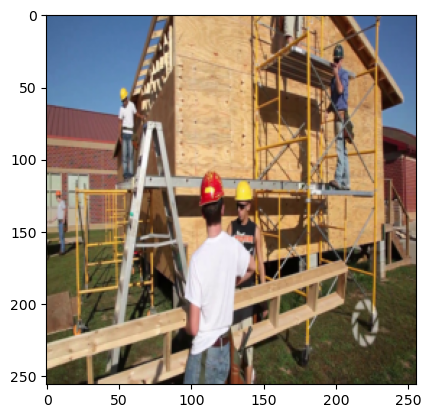

In [101]:
plt.imshow(pose_data[0]['img'].permute(1,2,0).detach())

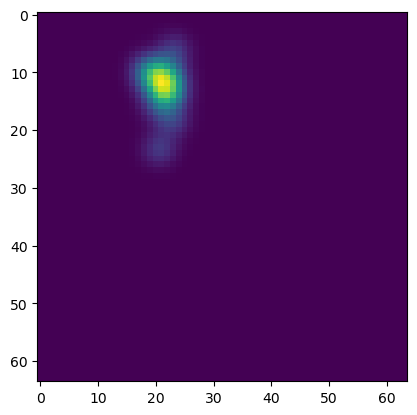

In [102]:
plt.imshow(pose_data[0]['label'].sum(axis=0))

In [103]:
class SkeletNet(Module):
    def __init__(self):
        super().__init__()
        self.cnn=resnet18(weights=ResNet18_Weights.DEFAULT)
        self.cnn=nn.Sequential(
            *list(self.cnn.children())[:-2]
        )
        
        self.dnn=nn.Sequential(
            nn.ConvTranspose2d(512,256,kernel_size=(4),stride=2,padding=1),#увеличивает размер в 2 раза
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256,256,kernel_size=(4),stride=2,padding=1),#увеличивает размер в 2 раза
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256,256,kernel_size=(4),stride=2,padding=1),#увеличивает размер в 2 раза
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        for lay in self.dnn:
            if isinstance(lay,nn.ConvTranspose2d):
                nn.init.normal_(lay.weight, std=0.001)
            # elif isinstance(lay,nn.BatchNorm2d):
            #     nn.init.constant_(lay.bias,0)

        
        self.predictor=nn.Sequential(
            nn.Conv2d(256,16,kernel_size=1)
        )

        for lay in self.predictor:
            if isinstance(lay,nn.ConvTranspose2d):
                nn.init.normal_(lay.weight, std=0.001)
        
    def forward(self,x):
        out=self.cnn(x)
        out=self.dnn(out)
        out=self.predictor(out)
        return out

In [104]:
model=SkeletNet()
optimizer=Adam(model.parameters())
loss_fn=MSELoss()

In [108]:
def Train(model,dataloader,optimizer,loss_fn,device):
    model.train()
    model=model.to(device)
    for batch in (pbar:=tqdm(dataloader)):
        optimizer.zero_grad()
        pred=model(batch['img'].to(device))
        loss=loss_fn(pred,batch['label'].to(device))
        loss.backward()
        loss_item=loss.item()

        pbar.set_description(f'{loss_item}')
        optimizer.step()
        #return batch['img'].to(device),pred

In [109]:
Train(model=model,dataloader=pose_dataloader,optimizer=optimizer,loss_fn=loss_fn,device=device)

0.0020465997513383627: 100%|█████████| 1561/1561 [07:45<00:00,  3.35it/s]


In [110]:
def get_keypoints_from_heatmaps(heatmap):
    c,h,w=heatmap.shape
    resh_heatmap=heatmap.reshape(c,-1)
    max_idx=resh_heatmap.argmax(dim=1)
    pred_x=(max_idx%w).float()
    pred_y=(max_idx//w).float()
    return pred_x,pred_y

In [95]:
def show_result(img,heatmap):
    img=img.permute(1,2,0).detach().cpu().numpy()
    full_heatmap=torch.max(heatmap,dim=0)[0].detach().cpu().numpy()

    px,py=get_keypoints_from_heatmaps(heatmap)

    #масштабирование
    scale=img.shape[0]/heatmap.shape[1]#хз
    px *=scale
    py *=scale

    plt.figure(figsize=(12,4))

    #1
    plt.subplot(1,3,1)
    plt.imshow(img)
    #2
    plt.subplot(1,3,2)
    plt.imshow(full_heatmap)
    #3
    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.scatter(px.cpu().numpy(),py.cpu().numpy(),c='red',s=20)

In [ ]:
for batch in pose_dataloader:
    pred=model(batch['img'].to(device))
    show_result(batch['img'][0],pred[0])
    

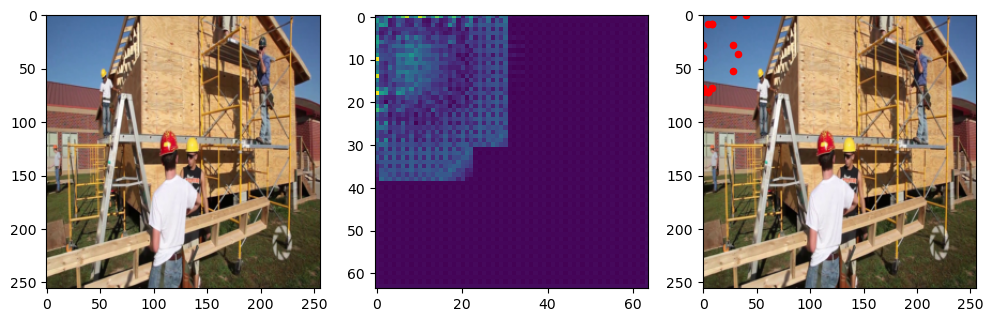

In [96]:
show_result(img[0],pred[0])